In [4]:
import os, sys
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import util

In [5]:
CLASS_CAP = 100

In [6]:
def extract_audio_segments(segments_df, segments_dir, sr=32000, segment_sec=5.0, 
                            threshold_factor=0.75, cap_per_class=CLASS_CAP):
    """
    Extract high-energy audio segments from audio files with balanced sampling per class.
    
    Args:
        segments_df (pd.DataFrame): DataFrame with 'filename', 'class_id', and 'author' columns
        segments_dir (str): Directory containing original audio .wav files
        sr (int): Target sampling rate
        segment_sec (float): Duration of each segment in seconds
        threshold_factor (float): RMS threshold factor for segment filtering
        cap_per_class (int): Maximum segments per class
        
    Returns:
        list: List of segment dictionaries with metadata including author
    """
    
    # Load and prepare audio files
    audio_files = util.load_audio_files(segments_df, segments_dir, sr, segment_sec, threshold_factor)
    
    if not audio_files:
        print("No valid audio files loaded!")
        return []
    
    print(f"Loaded {len(audio_files)} audio files successfully.")
    
    # Calculate total segments per class for metadata
    class_total_segments = util.calculate_class_totals(audio_files)
    
    # Extract segments with balanced sampling
    segments = util.extract_balanced_segments(audio_files, cap_per_class, segment_sec, sr, class_total_segments)
    
    print(f"Extracted {len(segments)} total segments")
    return segments

In [7]:
# Define Paths
audios_dir = os.path.join('..', 'database', 'audio', 'dev')
dev_df = pd.read_csv(os.path.join('..', 'database', 'meta', 'dev_data.csv'))

# Output directories for extracted segments
segments_output_dir = os.path.join('..', 'database', 'audio_segments')
segments_csv_path = os.path.join('..', 'database', 'meta', 'audio_segments.csv')

In [8]:
# Step 1: Extract audio segments and save to disk
util.clean_dir(segments_output_dir)

print("Extracting audio segments...")
segments = extract_audio_segments(
    dev_df, audios_dir, sr=32000, segment_sec=5.0, 
    threshold_factor=0.75, cap_per_class=CLASS_CAP
)

print(f"Extracted {len(segments)} segments total")

# Save segments to disk
print("Saving audio segments to disk...")
segments_df = util.save_audio_segments_to_disk(segments, segments_output_dir)
segments_df.to_csv(segments_csv_path, index=False)

print(f"Saved {len(segments_df)} audio segments to {segments_output_dir}")
print(f"Metadata saved to {segments_csv_path}")

Resetting ..\database\audio_segments directory...
Extracting audio segments...
Loaded 541 audio files successfully.
Extracted 2390 total segments
Extracted 2390 segments total
Saving audio segments to disk...
Saved 2390 audio segments to ..\database\audio_segments
Metadata saved to ..\database\meta\audio_segments.csv


In [9]:
# Check for repeated values in segments_df 'filename' column
filename_counts = segments_df['filename'].value_counts()
duplicates = filename_counts[filename_counts > 1]

if len(duplicates) > 0:
    print(f"Found {len(duplicates)} repeated filenames:")
    print(duplicates)
else:
    print("No repeated filenames found")

print(f"\nTotal unique filenames: {segments_df['filename'].nunique()}")
print(f"Total rows: {len(segments_df)}")

No repeated filenames found

Total unique filenames: 2390
Total rows: 2390


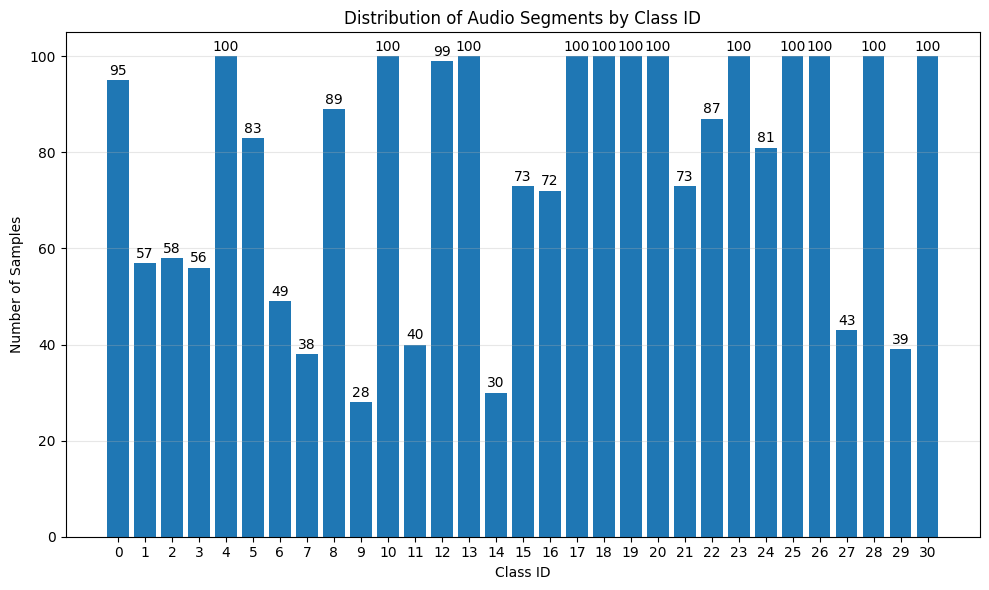

Class distribution:
Class 0: 95 samples
Class 1: 57 samples
Class 2: 58 samples
Class 3: 56 samples
Class 4: 100 samples
Class 5: 83 samples
Class 6: 49 samples
Class 7: 38 samples
Class 8: 89 samples
Class 9: 28 samples
Class 10: 100 samples
Class 11: 40 samples
Class 12: 99 samples
Class 13: 100 samples
Class 14: 30 samples
Class 15: 73 samples
Class 16: 72 samples
Class 17: 100 samples
Class 18: 100 samples
Class 19: 100 samples
Class 20: 100 samples
Class 21: 73 samples
Class 22: 87 samples
Class 23: 100 samples
Class 24: 81 samples
Class 25: 100 samples
Class 26: 100 samples
Class 27: 43 samples
Class 28: 100 samples
Class 29: 39 samples
Class 30: 100 samples


In [10]:
# Create histogram showing amount of samples for each class_id
class_counts = segments_df['class_id'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Class ID')
plt.ylabel('Number of Samples')
plt.title('Distribution of Audio Segments by Class ID')
plt.xticks(class_counts.index)
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for i, v in enumerate(class_counts.values):
    plt.text(class_counts.index[i], v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Class distribution:")
for class_id, count in class_counts.items():
    print(f"Class {class_id}: {count} samples")